In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Import L0 modules
from l0.layers import L0Linear

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


A direct comparison between L0 and L1 regularization showing the key differences. L0 produces exact sparsity (hard zeros) while L1 produces approximate sparsity (small but non-zero values).

In [2]:
# Create models for comparison
class L0LinearRegression(nn.Module):
    """Linear regression with L0 regularization."""
    def __init__(self, n_features, init_sparsity=0.9):
        super().__init__()
        self.l0_linear = L0Linear(
            n_features, 1,
            bias=False,
            init_sparsity=init_sparsity,
            temperature=0.5
        )

    def forward(self, x):
        return self.l0_linear(x).squeeze()

    def get_l0_loss(self):
        return self.l0_linear.get_l0_penalty()

    def get_sparsity(self):
        return self.l0_linear.get_sparsity()

class L1Linear(nn.Module):
    """Standard linear layer with L1 regularization."""
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features, bias=False)

    def forward(self, x):
        return self.linear(x).squeeze()

    def get_l1_penalty(self):
        return self.linear.weight.abs().sum()

    def get_sparsity(self, threshold=1e-3):
        return (self.linear.weight.abs() < threshold).float().mean().item()

# Train both models on the same data
n_features = 100
X_train = torch.randn(500, n_features)
y_train = torch.randn(500)

# L0 model
l0_model = L0LinearRegression(n_features, init_sparsity=0.1).to(device)
l0_optimizer = optim.Adam(l0_model.parameters(), lr=0.01)

# L1 model
l1_model = L1Linear(n_features, 1).to(device)
l1_optimizer = optim.Adam(l1_model.parameters(), lr=0.01)

l0_sparsities = []
l1_sparsities = []

print("Training models...")
for epoch in range(100):
    # Train L0
    l0_optimizer.zero_grad()
    l0_pred = l0_model(X_train.to(device))
    l0_mse = F.mse_loss(l0_pred, y_train.to(device))
    l0_total = l0_mse + 0.01 * l0_model.get_l0_loss()
    l0_total.backward()
    l0_optimizer.step()
    l0_sparsities.append(l0_model.get_sparsity())

    # Train L1
    l1_optimizer.zero_grad()
    l1_pred = l1_model(X_train.to(device))
    l1_mse = F.mse_loss(l1_pred, y_train.to(device))
    l1_total = l1_mse + 0.01 * l1_model.get_l1_penalty()
    l1_total.backward()
    l1_optimizer.step()
    l1_sparsities.append(l1_model.get_sparsity())

print(f"\nFinal L0 sparsity: {l0_sparsities[-1]:.2%}")
print(f"Final L1 sparsity: {l1_sparsities[-1]:.2%}")

Training models...

Final L0 sparsity: 3.89%
Final L1 sparsity: 7.00%


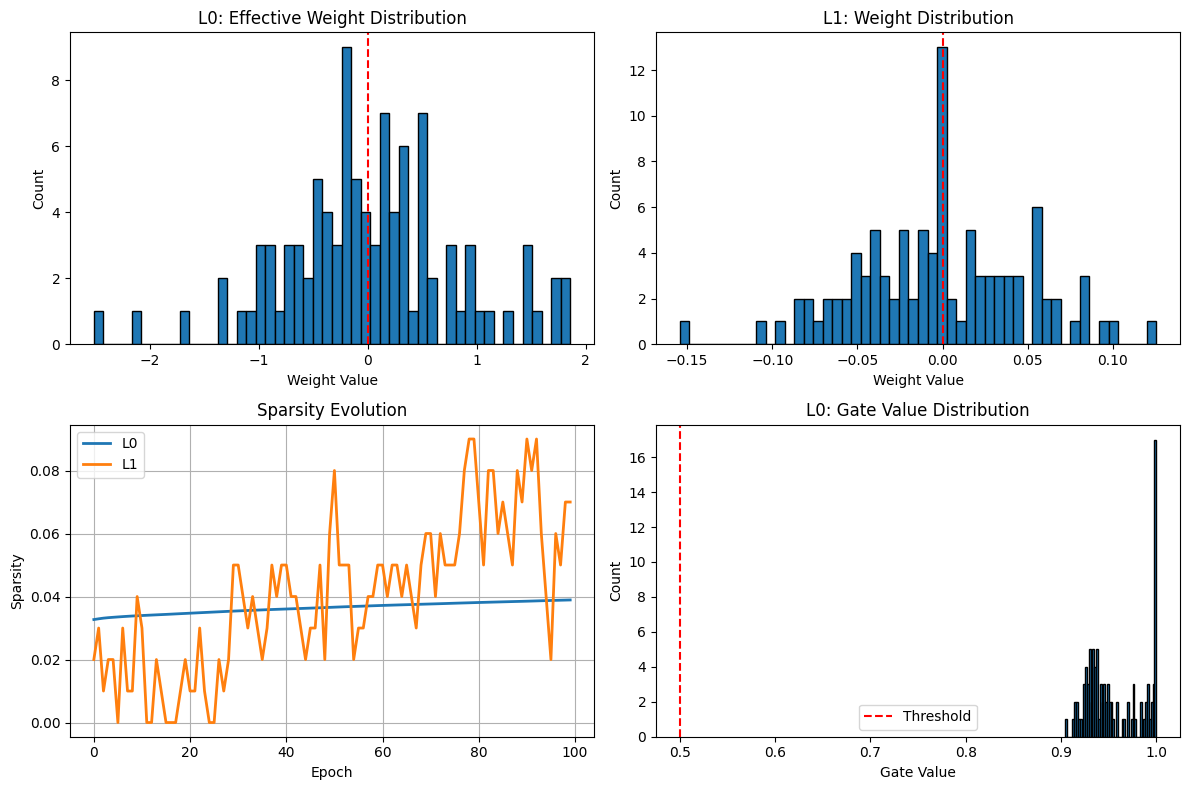


Exact zeros - L0: 0/100, L1: 7/100


In [3]:
# Compare weight distributions
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# L0 weights
l0_model.eval()
with torch.no_grad():
    l0_weights = l0_model.l0_linear.weight.squeeze().cpu().numpy()
    l0_gates = l0_model.l0_linear.weight_gates().squeeze().cpu().numpy()
    l0_effective = l0_weights * l0_gates

# L1 weights
l1_weights = l1_model.linear.weight.squeeze().detach().cpu().numpy()

# Plot weight distributions
axes[0, 0].hist(l0_effective, bins=50, edgecolor='black')
axes[0, 0].set_title('L0: Effective Weight Distribution')
axes[0, 0].set_xlabel('Weight Value')
axes[0, 0].set_ylabel('Count')
axes[0, 0].axvline(x=0, color='r', linestyle='--')

axes[0, 1].hist(l1_weights, bins=50, edgecolor='black')
axes[0, 1].set_title('L1: Weight Distribution')
axes[0, 1].set_xlabel('Weight Value')
axes[0, 1].set_ylabel('Count')
axes[0, 1].axvline(x=0, color='r', linestyle='--')

# Plot sparsity evolution
axes[1, 0].plot(l0_sparsities, label='L0', linewidth=2)
axes[1, 0].plot(l1_sparsities, label='L1', linewidth=2)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Sparsity')
axes[1, 0].set_title('Sparsity Evolution')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot gate distribution for L0
axes[1, 1].hist(l0_gates, bins=50, edgecolor='black')
axes[1, 1].set_title('L0: Gate Value Distribution')
axes[1, 1].set_xlabel('Gate Value')
axes[1, 1].set_ylabel('Count')
axes[1, 1].axvline(x=0.5, color='r', linestyle='--', label='Threshold')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Count exact zeros
l0_zeros = (l0_gates < 0.5).sum()
l1_zeros = (np.abs(l1_weights) < 1e-3).sum()
print(f"\nExact zeros - L0: {l0_zeros}/{n_features}, L1: {l1_zeros}/{n_features}")